In [1]:
# import neccesities
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import collections
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import SphericalVoronoi
from scipy.spatial import ConvexHull
import math

# set constants
NPOINTS = 500
RADIUS = 4000
CENTER = np.array([0, 0, 0])

In [2]:
# generate NPOINTS random points
points = np.random.randn(3, NPOINTS)

# normalization function
def noramlize(points, radius=1):
    points /= np.linalg.norm(points, axis=0)
    return points * radius

# normalize to sphere
points = noramlize(points, radius=RADIUS)

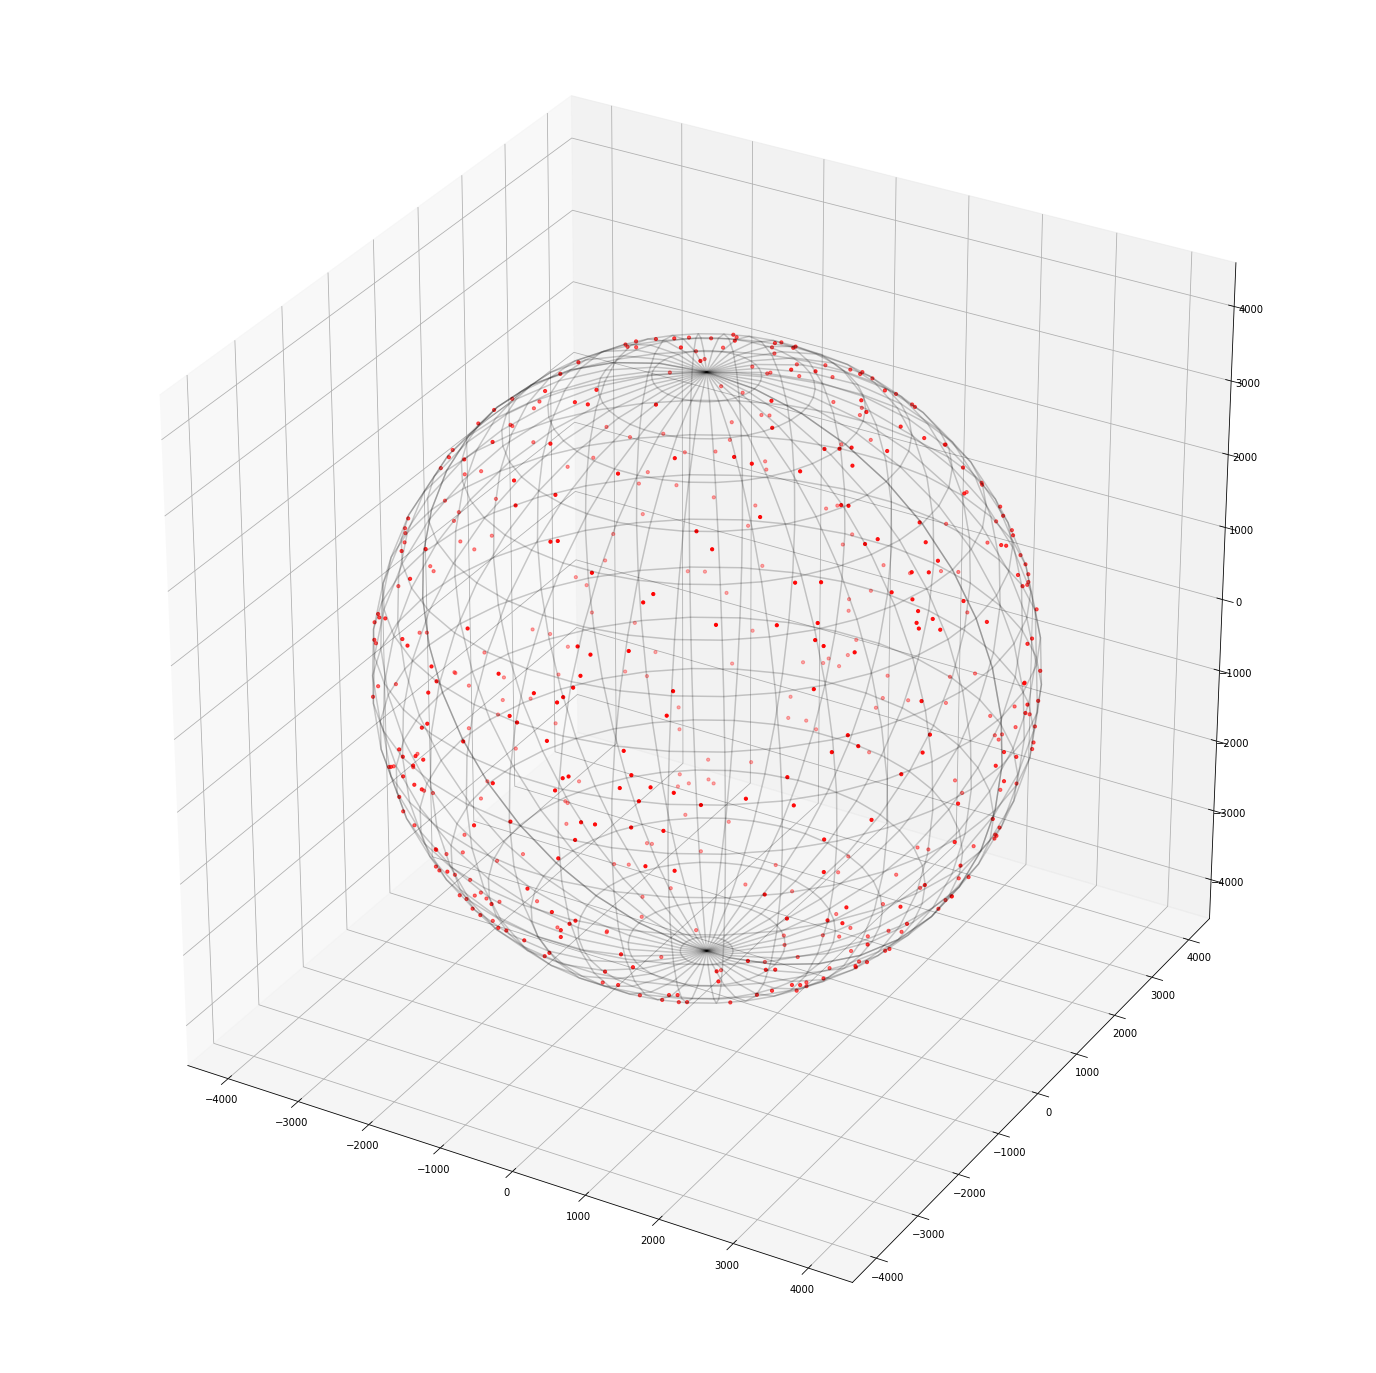

In [3]:
# generate gridlines
phi = np.linspace(0, np.pi, 20)
theta = np.linspace(0, 2 * np.pi, 40)
x = np.outer(np.sin(theta) * np.sqrt(RADIUS), np.cos(phi) * np.sqrt(RADIUS))
y = np.outer(np.sin(theta) * np.sqrt(RADIUS), np.sin(phi) * np.sqrt(RADIUS))
z = np.outer(np.cos(theta) * np.sqrt(RADIUS), np.ones_like(phi) * np.sqrt(RADIUS))

# plot gridlines + smaple points
fig, ax = plt.subplots(1, 1,figsize=(25,25), subplot_kw={'projection':'3d', 'aspect':'equal'})
ax.plot_wireframe(x, y, z, alpha=0.2, color='k', rstride=1, cstride=1)
ax.scatter(points[0], points[1], points[2], s=10, c='r', zorder=10)

# remove axis and gridlines
# plt.axis('off')
# ax.grid(False)

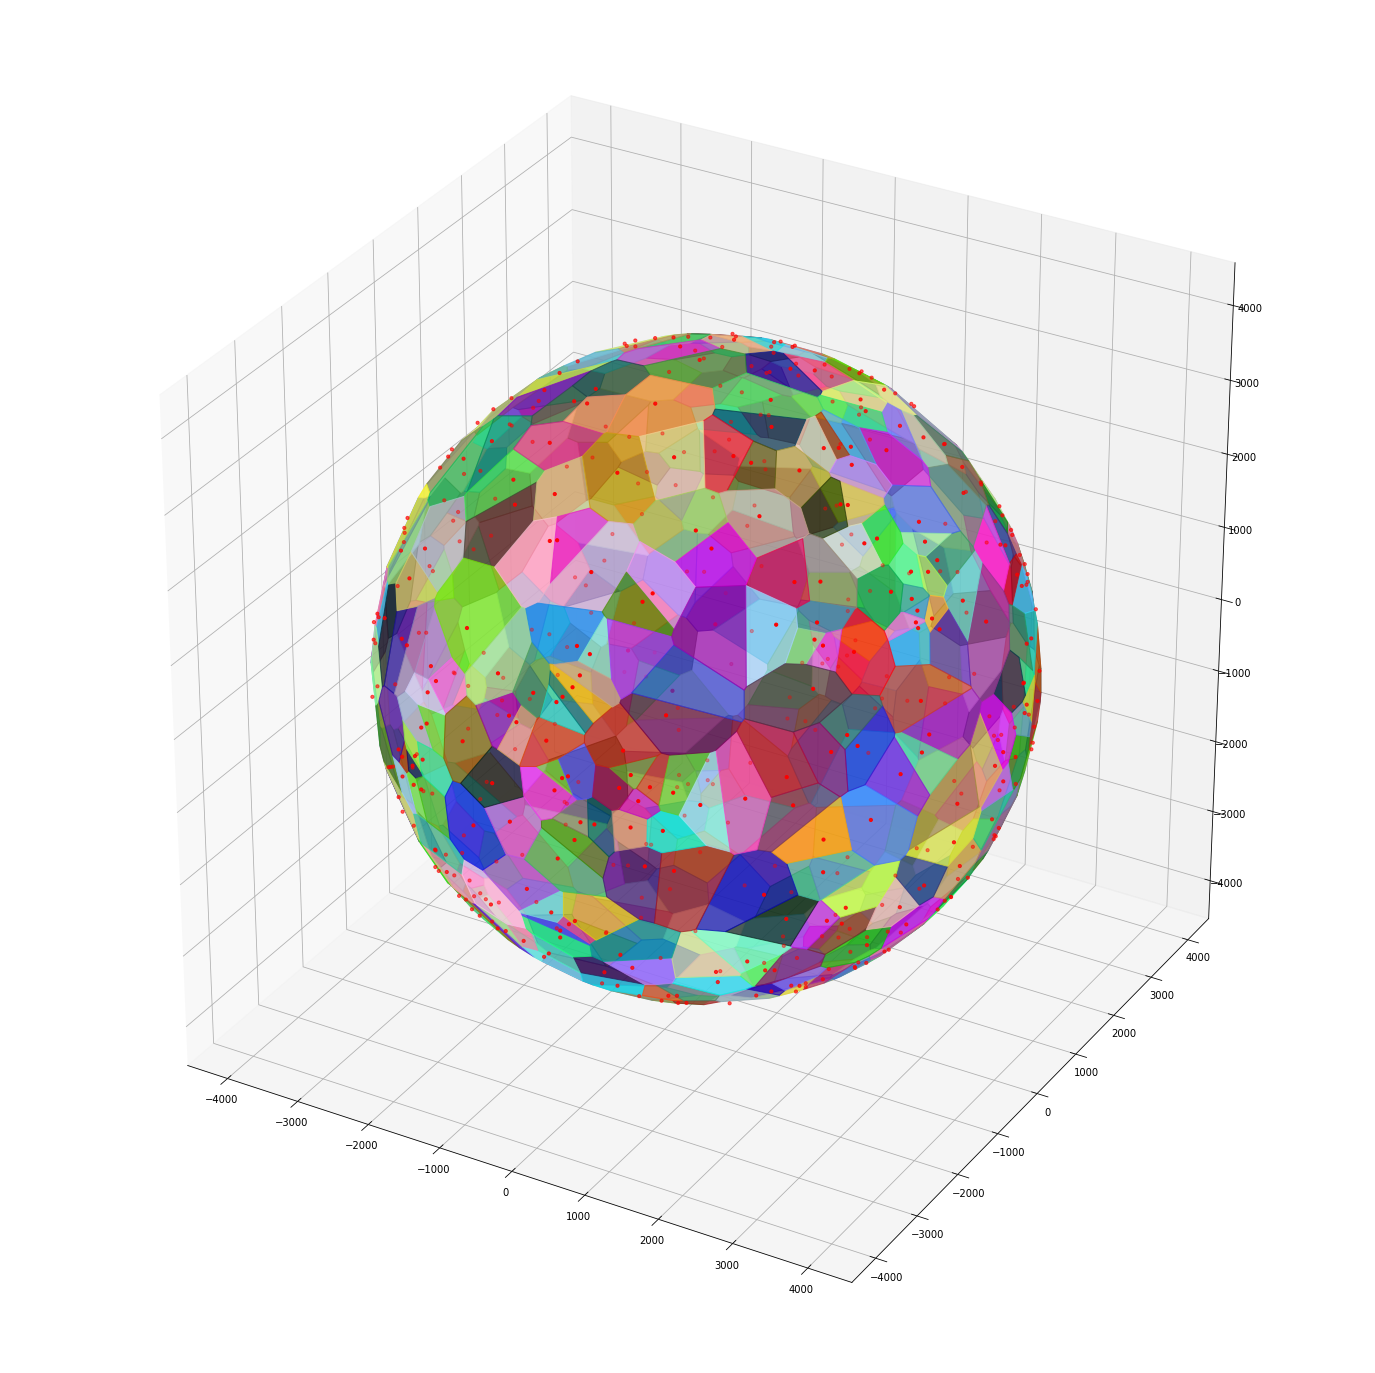

In [4]:
# use spherical voronoi
points = np.array(list(zip(points[0], points[1], points[2])))
sv = SphericalVoronoi(points, RADIUS, CENTER)
sv.sort_vertices_of_regions()

# plot spherical voronoi
# plot points
fig, ax = plt.subplots(1, 1,figsize=(25,25), subplot_kw={'projection':'3d', 'aspect':'equal'})
ax.scatter(points[:,0], points[:,1], points[:,2], s=10, c='r', zorder=15)

# plot regions
for region in sv.regions:
    random_color = colors.rgb2hex(np.random.rand(3))
    polygon = Poly3DCollection([sv.vertices[region]], alpha=0.7)
    polygon.set_color(random_color)
    ax.add_collection3d(polygon)

# plt.axis('off')
# ax.grid(False)

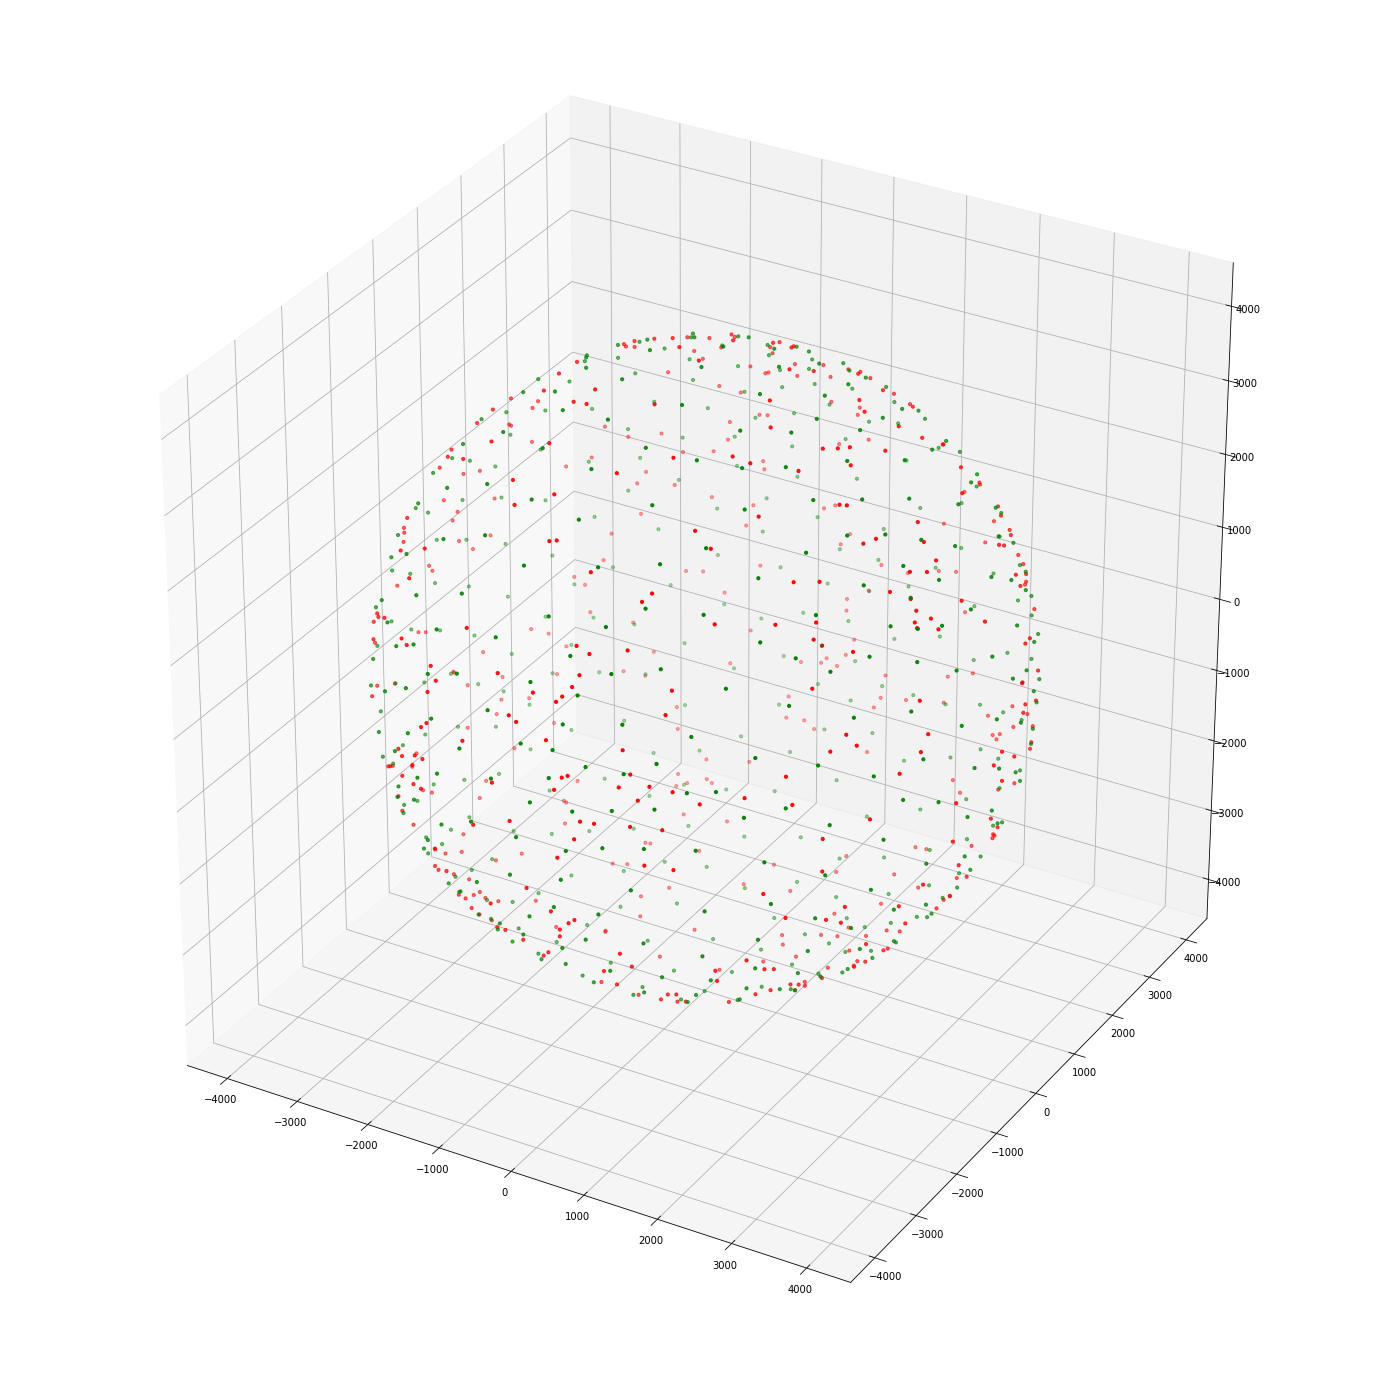

In [5]:
# perform voronoi iteration

# centroid func
def find_centroid(vertices):
    x = np.mean([vertex[0] for vertex in vertices])
    y = np.mean([vertex[1] for vertex in vertices])
    z = np.mean([vertex[2] for vertex in vertices])
    return [x, y, z]

def normalize(p, r=1):
    p /= np.linalg.norm(p, axis=0)
    return p * r

# relaxation iterator
def relaxation(points, num_iter=1):
    relaxed, sv = points, SphericalVoronoi(points, RADIUS, CENTER)
    while num_iter > 0:
        sv = SphericalVoronoi(relaxed, RADIUS, CENTER)
        relaxed = np.array([normalize(find_centroid(sv.vertices[region]), RADIUS) for region in sv.regions])
        num_iter -= 1
    return sv.points, sv

# run relexation 50 times
old_points = points
points, sv = relaxation(points, 20)
sv.sort_vertices_of_regions()
 
# plot new relaxed points
fig, ax = plt.subplots(1, 1,figsize=(25,25), subplot_kw={'projection':'3d', 'aspect':'equal'})
ax.scatter(old_points[:,0], old_points[:,1], old_points[:,2], s=10, c='r', zorder=15)
ax.scatter(points[:,0], points[:,1], points[:,2], s=10, c='g', zorder=15)



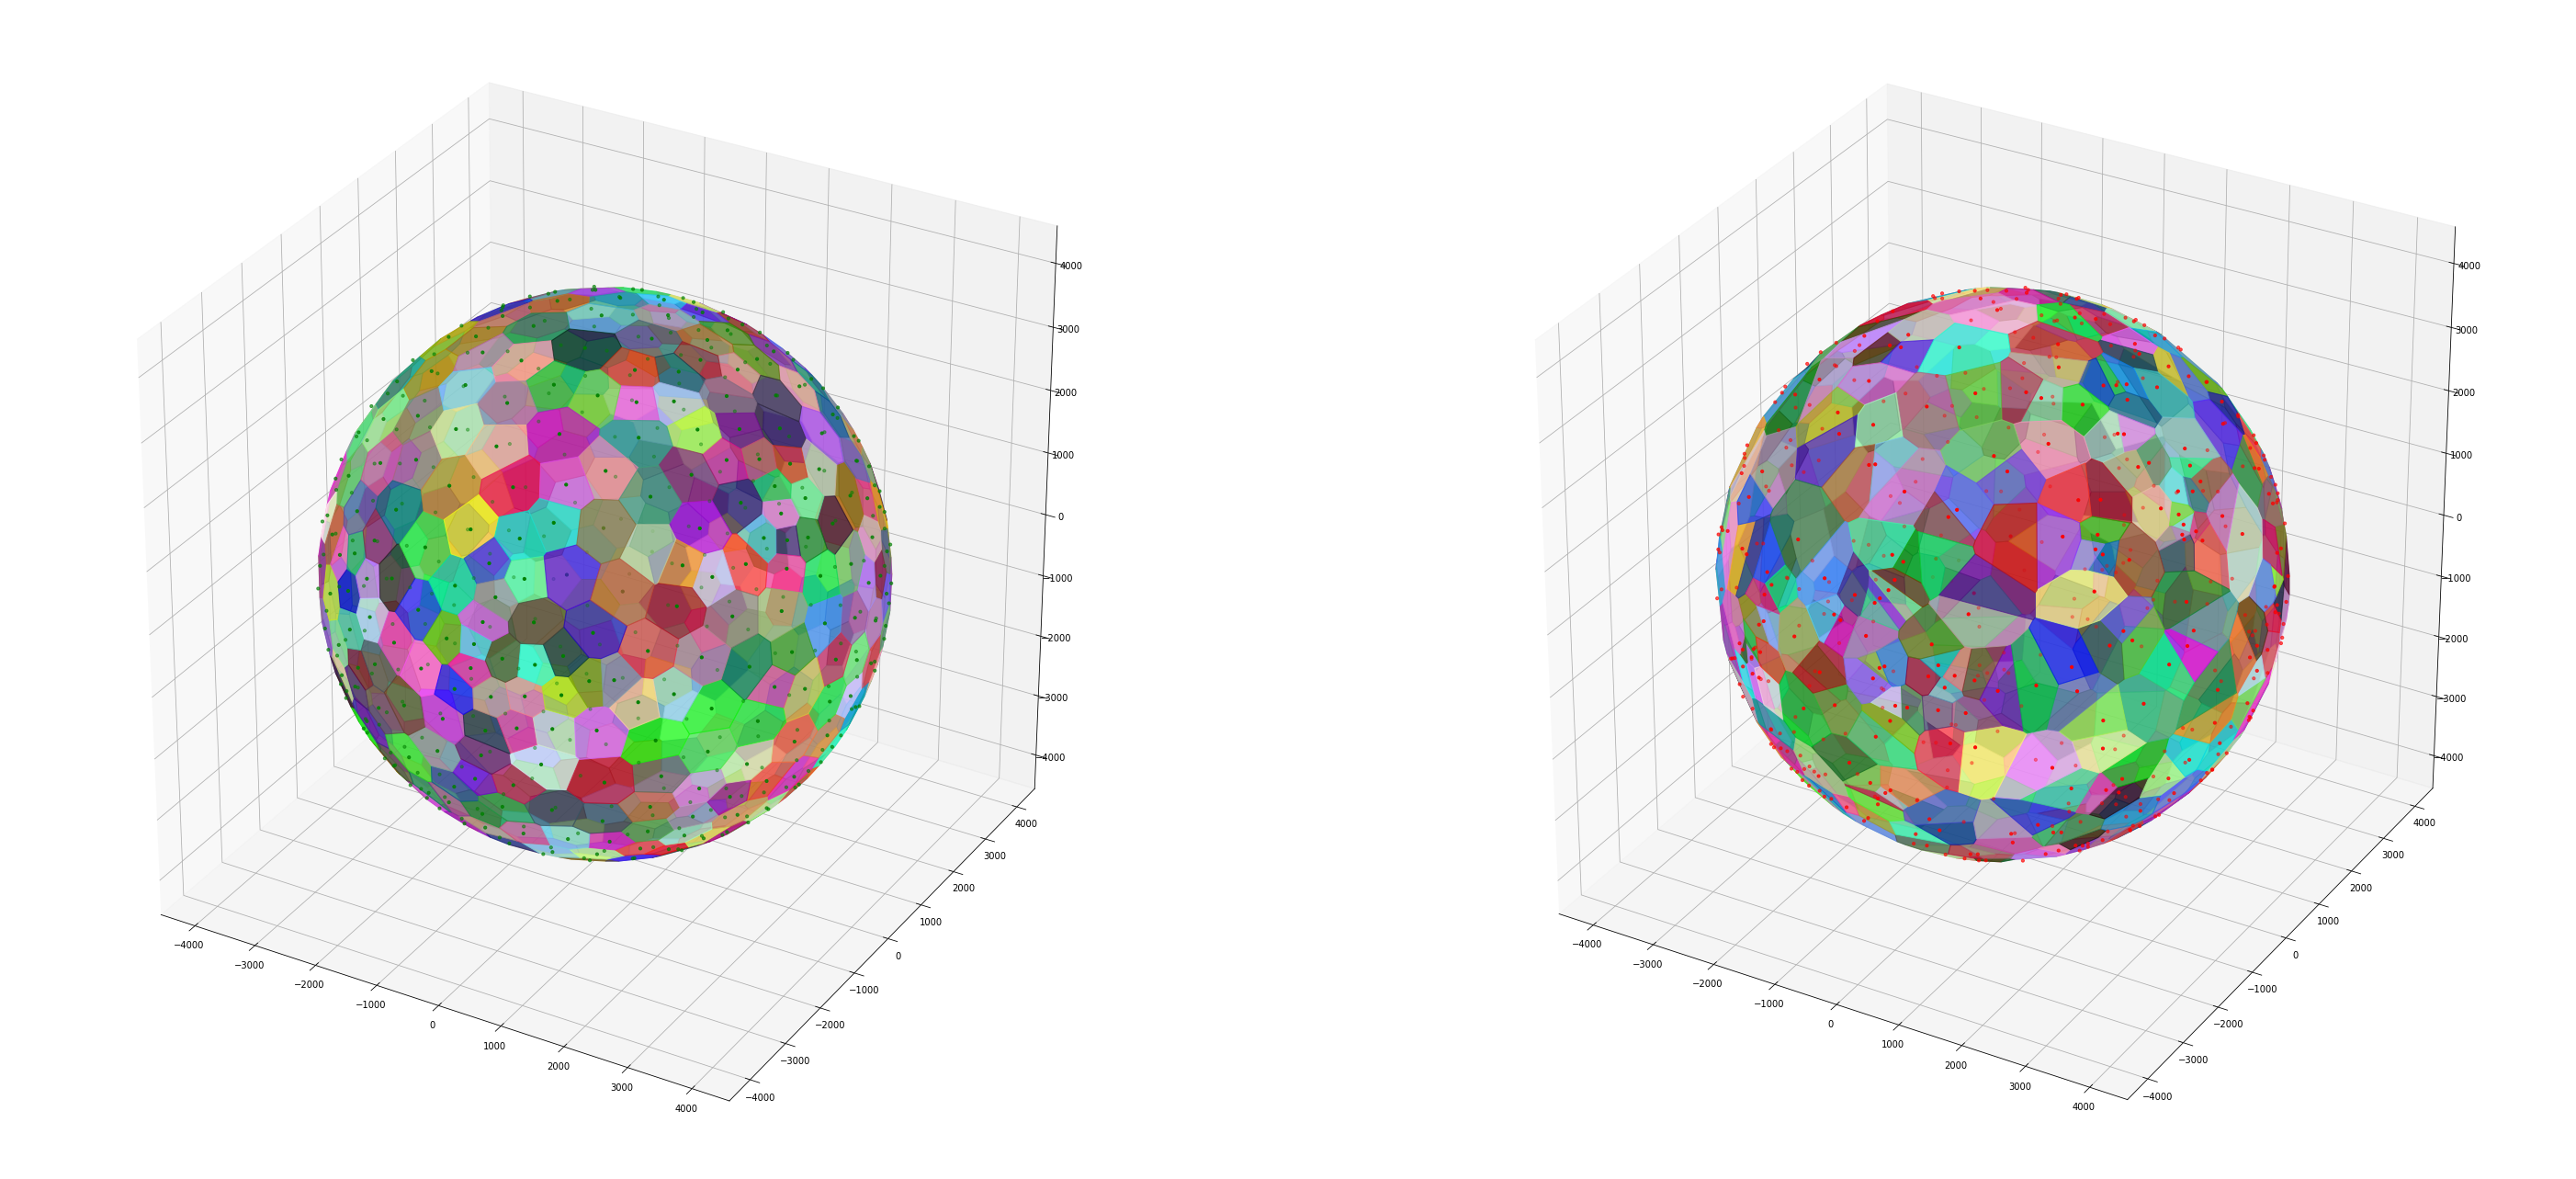

In [6]:
# compare new and old points
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(50,25), subplot_kw={'projection':'3d', 'aspect':'equal'})

# plot new points
ax1.scatter(points[:,0], points[:,1], points[:,2], s=10, c='g', zorder=15)

# plot old points
ax2.scatter(old_points[:,0], old_points[:,1], old_points[:,2], s=10, c='r', zorder=15)

# plot regions with matching colors
old_sv = SphericalVoronoi(old_points, RADIUS, CENTER)
old_sv.sort_vertices_of_regions()

for i in range(len(sv.regions)):
    random_color = colors.rgb2hex(np.random.rand(3))
    polygon = Poly3DCollection([sv.vertices[sv.regions[i]]], alpha=0.7)
    polygon.set_color(random_color)
    ax1.add_collection3d(polygon)
    
    random_color = colors.rgb2hex(np.random.rand(3))
    old_polygon = Poly3DCollection([old_sv.vertices[old_sv.regions[i]]], alpha=0.7)
    old_polygon.set_color(random_color)
    ax2.add_collection3d(old_polygon)
   

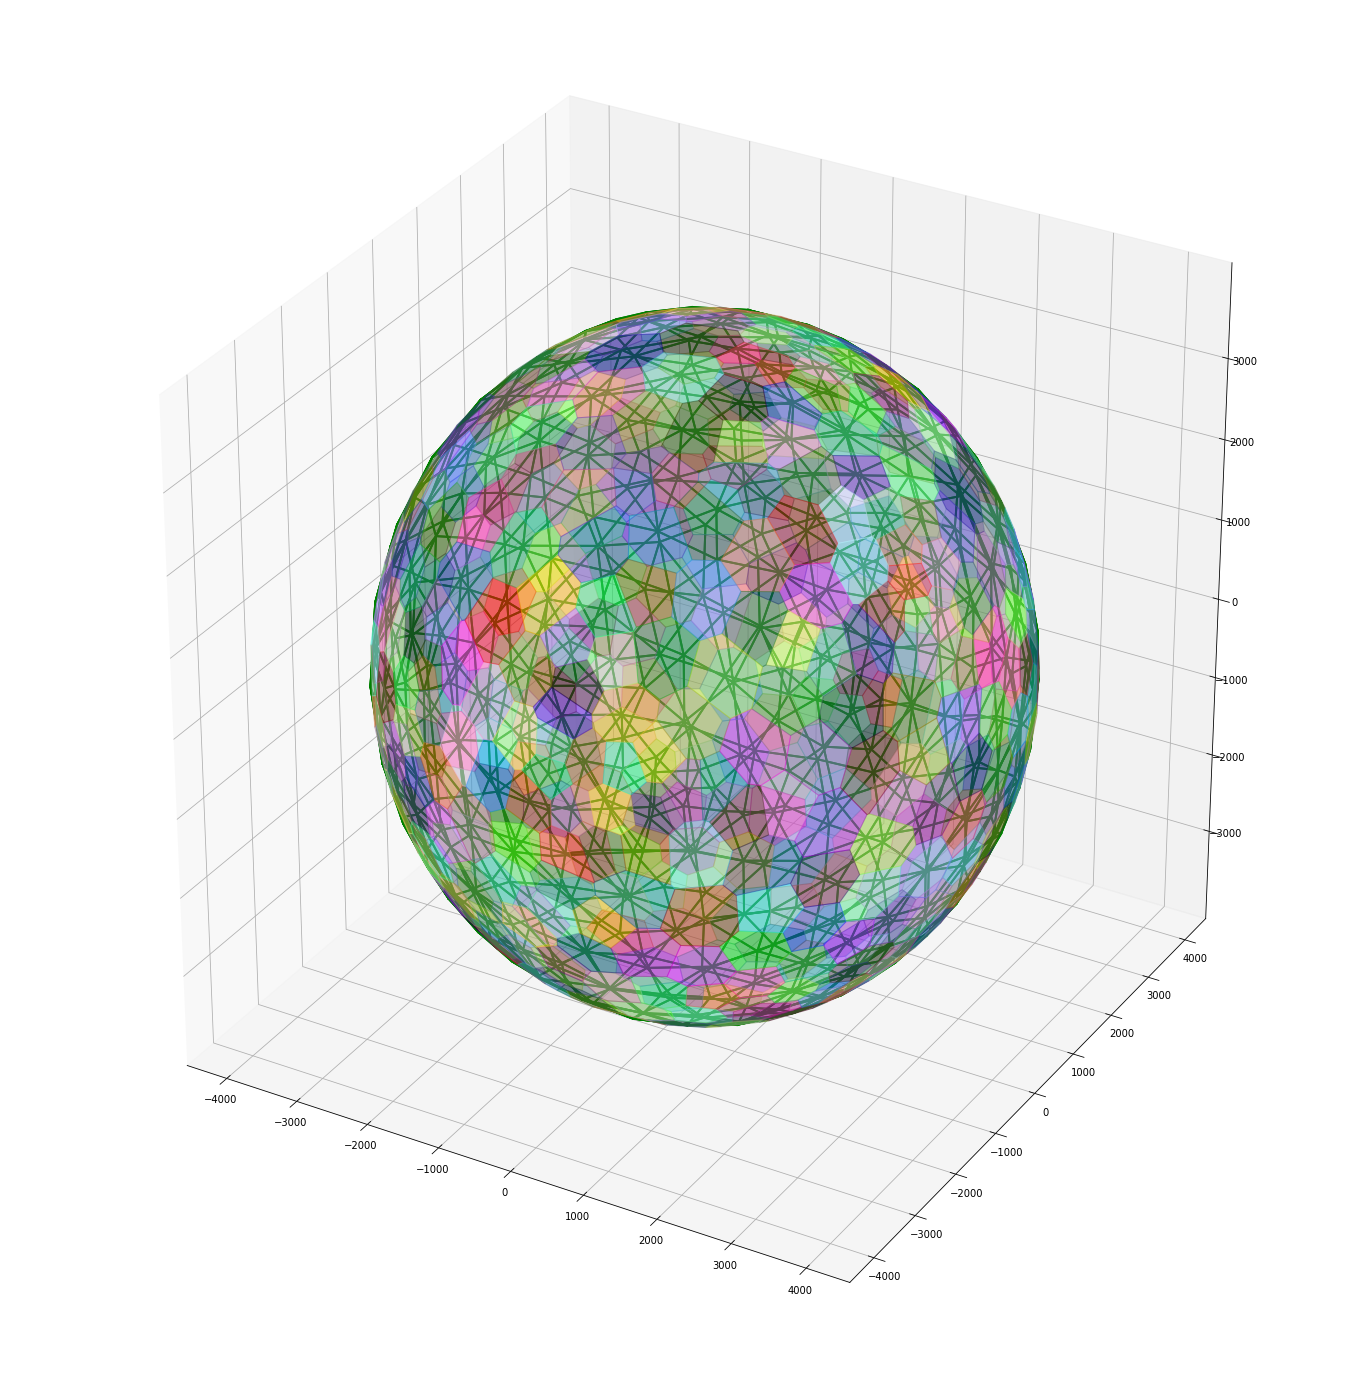

In [7]:
# compute convex hull of spherical points
hull = ConvexHull(points, incremental=False)

# plot convex hull
fig, ax = plt.subplots(1, 1,figsize=(25,25), subplot_kw={'projection':'3d', 'aspect':'equal'})

for simplex in hull.simplices:
    simplex = np.append(simplex, simplex[0])
    plt.plot(points[simplex, 0], points[simplex, 1], points[simplex, 2], linewidth=2, c='g')

for region in sv.regions:
    random_color = colors.rgb2hex(np.random.rand(3))
    polygon = Poly3DCollection([sv.vertices[region]], alpha=0.4)
    polygon.set_color(random_color)
    ax.add_collection3d(polygon)



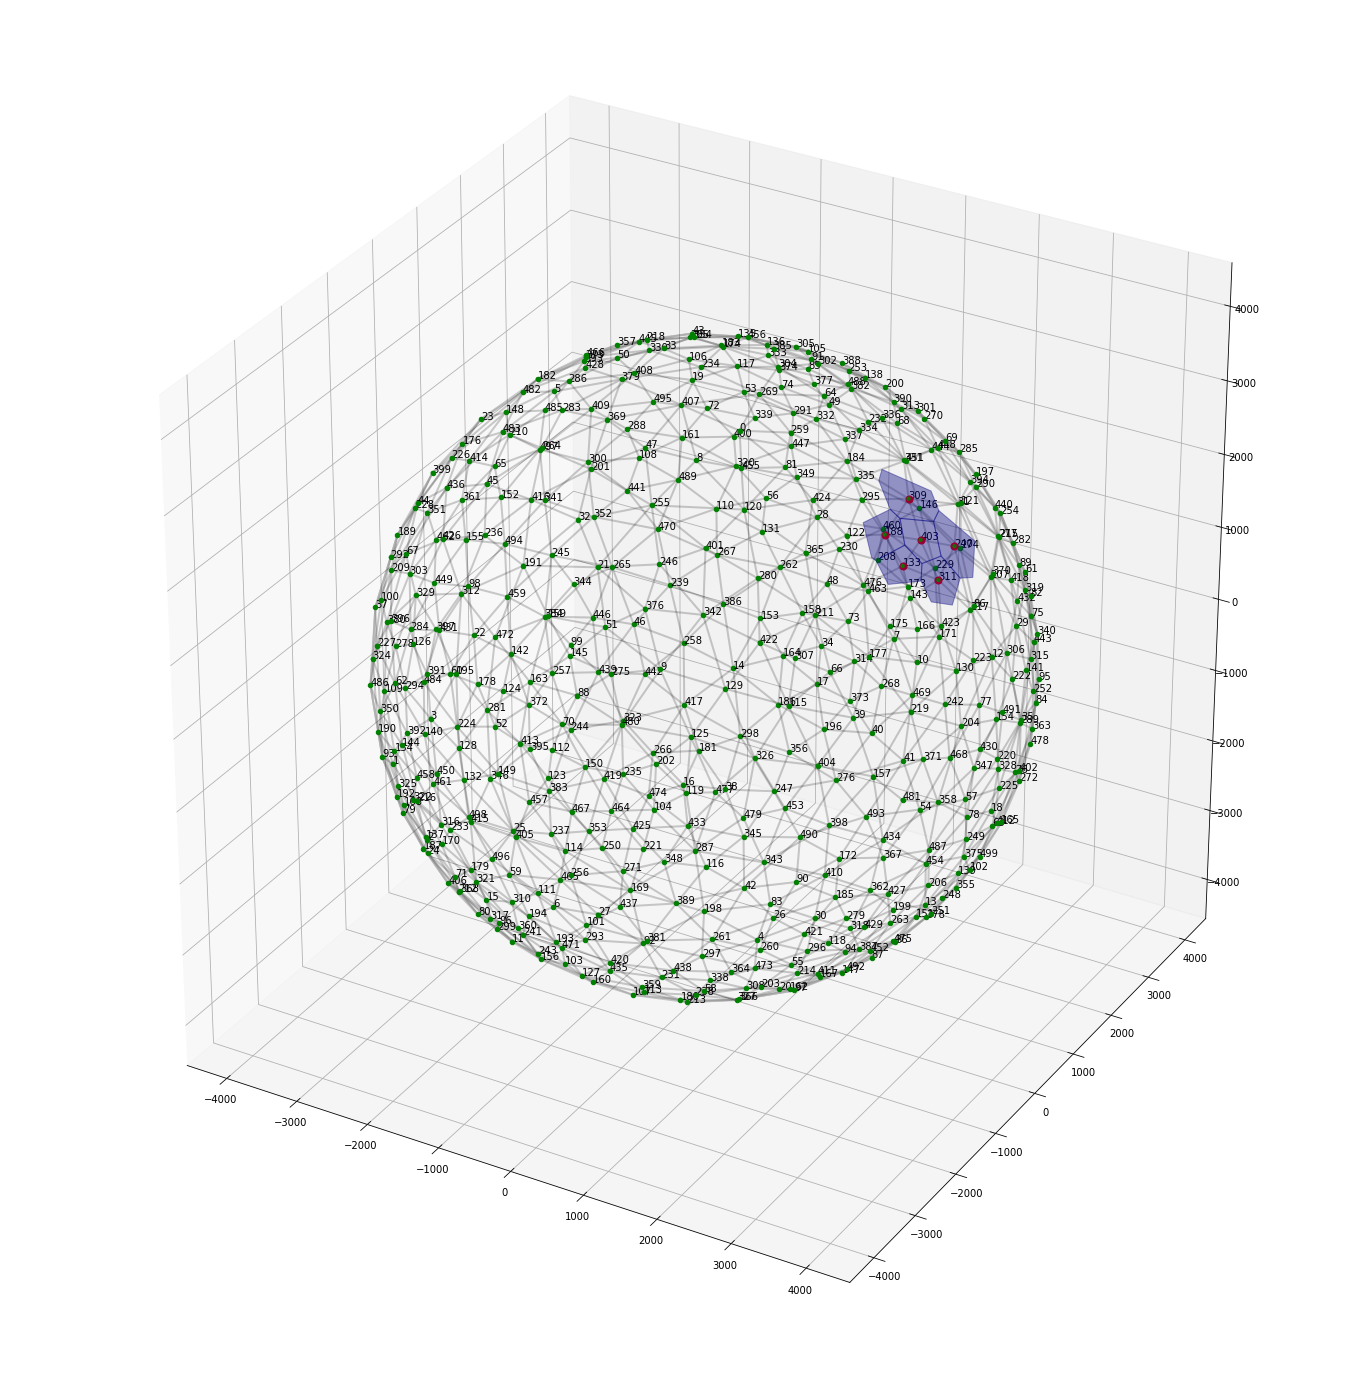

In [8]:
# combine convex hull and spherical voronoi data into combined class

# first determine convex hull data
# first rearrange simplex indices such that it is sorted
simplices = hull.simplices[:]

# we use lists (implemented as arrays) as the information is static
# each element is a list containing indices of neighbors
nodes = [set() for i in range(NPOINTS)]
for simplex in simplices:
    nodes[simplex[0]].update([simplex[1], simplex[2]])
    nodes[simplex[1]].update([simplex[0], simplex[2]])
    nodes[simplex[2]].update([simplex[0], simplex[1]])

# let's see if everything works
fig, ax = plt.subplots(1, 1,figsize=(25,25), subplot_kw={'projection':'3d', 'aspect':'equal'})

ax.scatter(points[:,0], points[:,1], points[:,2], s=10, c='g', zorder=15)

# plot points
for i in range(NPOINTS):
    ax.scatter(points[i,0], points[i,1], points[i,2], color='g')
    ax.text(points[i,0], points[i,1], points[i,2], '{}'.format(i), size=10, zorder=20, color='k')
    
# select random simplex
import random
rand = random.randint(0, NPOINTS)


# construct indices
indices = list(nodes[rand]) + [rand]

# plot points and regions
for i in range(len(indices)):
    point = sv.points[indices[i]]
    region = sv.regions[indices[i]]

    ax.scatter(point[0], point[1], point[2], s=50, c='r')
    polygon = Poly3DCollection([sv.vertices[region]], alpha=0.4)
    polygon.set_color('navy')
    ax.add_collection3d(polygon)

for simplex in hull.simplices:
    simplex = np.append(simplex, simplex[0])
    plt.plot(points[simplex, 0], points[simplex, 1], points[simplex, 2], linewidth=2, c='k', alpha=0.1)








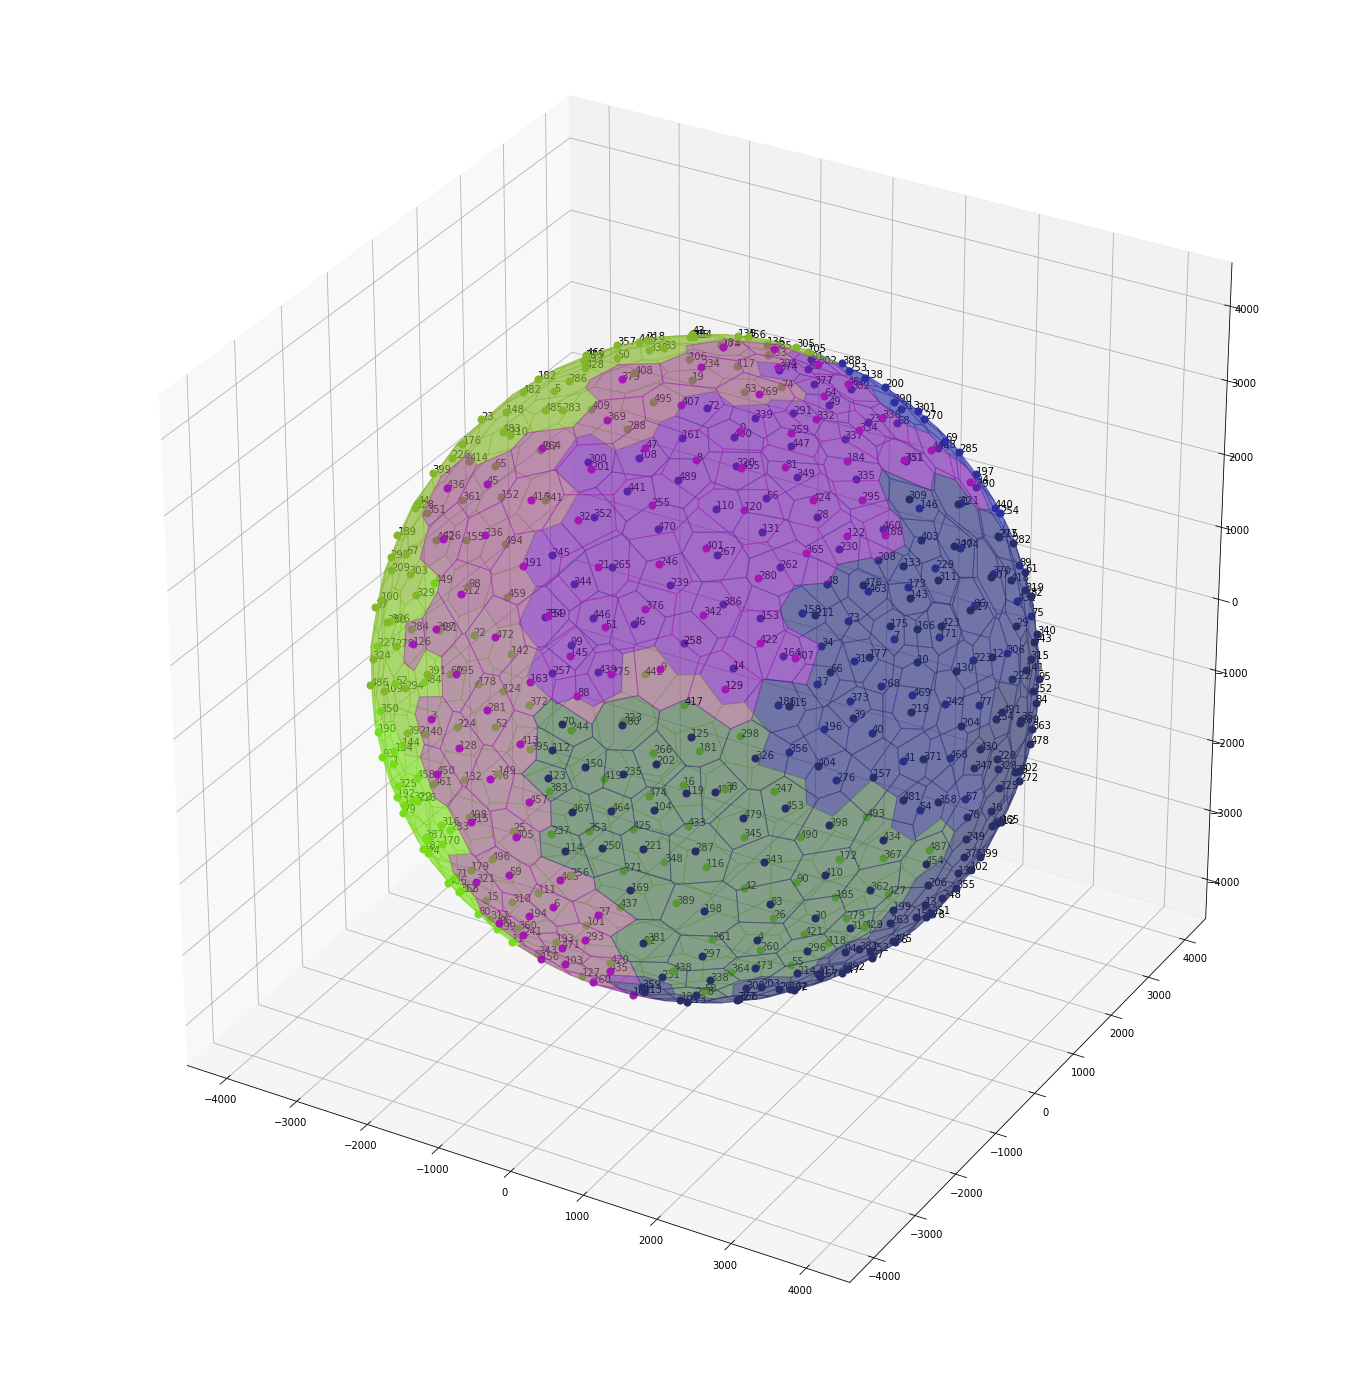

In [12]:
# let's now create tectonic plates
NPLATES = 5

# create plates data structure
plates = [set() for i in range(NPLATES)]
unassigned_nodes = set(range(NPOINTS))

# allocate a random starting location
for plate in plates:
    start = random.sample(unassigned_nodes,k=1)[0]
    unassigned_nodes.remove(start)
    plate.add(start)

    
# perform random fill
while len(unassigned_nodes) > 0:
    added_node = None
    plate = None
    while added_node not in unassigned_nodes:
        plate = random.choice(plates)
        added_node = None
        fill_from = random.sample(plate,k=1)[0]
        added_node = random.sample(nodes[fill_from],k=1)[0]
    plate.add(added_node)
    unassigned_nodes.remove(added_node)
    
fig, ax = plt.subplots(1, 1,figsize=(25,25), subplot_kw={'projection':'3d', 'aspect':'equal'})

# plot points
for i in range(NPOINTS):
    ax.scatter(points[i,0], points[i,1], points[i,2], color='g')
    ax.text(points[i,0], points[i,1], points[i,2], '{}'.format(i), size=10, zorder=20, color='k')

for plate in plates:
    random_color = colors.rgb2hex(np.random.rand(3))
    indices = list(plate)
    for i in range(len(indices)):
        point = sv.points[indices[i]]
        region = sv.regions[indices[i]]

        ax.scatter(point[0], point[1], point[2], s=50, c=random_color)
        polygon = Poly3DCollection([sv.vertices[region]], alpha=0.4)
        polygon.set_color(random_color)
        ax.add_collection3d(polygon)
    